# Import Libraries

In [63]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind

# Obtain Data

Read csv file with combine data into pandas

In [43]:
df = pd.read_csv('Data/Combine_Data.csv')
df.head()

,Year,Player,Position,School,College Stats,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle,Draft
0,2015,Ameer Abdullah,RB,Nebraska,College Stats,5-9,205.0,4.60,42.5,24.0,130.0,6.79,3.95,Detroit Lions / 2nd / 54th pick / 2015
1,2015,Nelson Agholor,WR,USC,College Stats,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN,Philadelphia Eagles / 1st / 20th pick / 2015
2,2015,Jay Ajayi,RB,Boise State,College Stats,6-0,221.0,4.57,39.0,19.0,121.0,7.10,4.10,Miami Dolphins / 5th / 149th pick / 2015
3,2015,Kwon Alexander,OLB,LSU,College Stats,6-1,227.0,4.55,36.0,24.0,121.0,7.14,4.20,Tampa Bay Buccaneers / 4th / 124th pick / 2015
4,2015,Mario Alford,WR,West Virginia,College Stats,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07,Cincinnati Bengals / 7th / 238th pick / 2015


Filter df to only include WR and CB Position players

In [44]:
df = df[(df['Position'] == 'WR') | (df['Position'] == 'CB')]
df.reset_index(drop=True, inplace=True)
print('df shape:', df.shape)
df.head()

df shape: (506, 14)


,Year,Player,Position,School,College Stats,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle,Draft
0,2015,Nelson Agholor,WR,USC,College Stats,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN,Philadelphia Eagles / 1st / 20th pick / 2015
1,2015,Mario Alford,WR,West Virginia,College Stats,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07,Cincinnati Bengals / 7th / 238th pick / 2015
2,2015,Dres Anderson,WR,Utah,College Stats,6-1,187.0,4.54,NaN,13.0,NaN,NaN,NaN,NaN
3,2015,Kenny Bell,WR,Nebraska,College Stats,6-1,197.0,4.42,41.5,7.0,129.0,6.66,4.15,Tampa Bay Buccaneers / 5th / 162nd pick / 2015
4,2015,Da'Ron Brown,WR,Northern Illinois,College Stats,6-0,205.0,4.54,37.0,17.0,120.0,7.04,4.11,Kansas City Chiefs / 7th / 233rd pick / 2015


# Scrub Data

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           506 non-null    int64  
 1   Player         506 non-null    object 
 2   Position       506 non-null    object 
 3   School         506 non-null    object 
 4   College Stats  464 non-null    object 
 5   Height         506 non-null    object 
 6   Weight         506 non-null    float64
 7   40 Yd Dash     453 non-null    float64
 8   Vertical       424 non-null    float64
 9   Bench          385 non-null    float64
 10  Broad Jump     420 non-null    float64
 11  3 Cone         299 non-null    float64
 12  Shuttle        309 non-null    float64
 13  Draft          318 non-null    object 
dtypes: float64(7), int64(1), object(6)
memory usage: 55.5+ KB


Drop columns not useful for modeling

In [46]:
df.drop(columns=['Draft', 'School', 'Player', 'College Stats'], inplace=True)
df.head()

,Year,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,2015,WR,6-0,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,2015,WR,5-8,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,2015,WR,6-1,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,2015,WR,6-1,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,2015,WR,6-0,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Change height units to inches and update to int data type

In [47]:
def feet_to_inches(val):
    return int(val.split('-')[0])*12 + int(val.split('-')[1])
df['Height'] = df['Height'].apply(feet_to_inches)
df.head()

,Year,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,2015,WR,72,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,2015,WR,68,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,2015,WR,73,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,2015,WR,73,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,2015,WR,72,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Numerically code Position variable

In [48]:
df['Position'] = df['Position'].replace({'CB':0, 'WR':1})
df.head()

,Year,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,3 Cone,Shuttle
0,2015,1,72,198.0,4.42,NaN,12.0,NaN,NaN,NaN
1,2015,1,68,180.0,4.43,34.0,13.0,121.0,6.64,4.07
2,2015,1,73,187.0,4.54,NaN,13.0,NaN,NaN,NaN
3,2015,1,73,197.0,4.42,41.5,7.0,129.0,6.66,4.15
4,2015,1,72,205.0,4.54,37.0,17.0,120.0,7.04,4.11


Drop features missing more than one quarter of values

In [49]:
df.drop(columns=['3 Cone', 'Shuttle'], inplace=True)
df.head()

,Year,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump
0,2015,1,72,198.0,4.42,NaN,12.0,NaN
1,2015,1,68,180.0,4.43,34.0,13.0,121.0
2,2015,1,73,187.0,4.54,NaN,13.0,NaN
3,2015,1,73,197.0,4.42,41.5,7.0,129.0
4,2015,1,72,205.0,4.54,37.0,17.0,120.0


Drop players missing 4 values

In [50]:
df = df[df.isna().sum(axis=1)<4]
print('df shape:', df.shape)
df.head()

df shape: (487, 8)


,Year,Position,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump
0,2015,1,72,198.0,4.42,NaN,12.0,NaN
1,2015,1,68,180.0,4.43,34.0,13.0,121.0
2,2015,1,73,187.0,4.54,NaN,13.0,NaN
3,2015,1,73,197.0,4.42,41.5,7.0,129.0
4,2015,1,72,205.0,4.54,37.0,17.0,120.0


Impute missing values

In [51]:
impute_x = df.drop(columns=['Position'])
impute_y = df['Position']
impute_x_train, impute_x_test, impute_y_train, impute_y_test = train_test_split(impute_x, impute_y, test_size=0.2,
                                                                                random_state=91)
impute_ss = StandardScaler()
impute_ss.fit(impute_x_train)
impute_x_train = pd.DataFrame(impute_ss.transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(impute_ss.transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

imputer = KNNImputer()
imputer.fit(impute_x_train)
impute_x_train = pd.DataFrame(imputer.transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(imputer.transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

impute_x_train = pd.DataFrame(impute_ss.inverse_transform(impute_x_train), columns=impute_x_train.columns, 
                              index=impute_x_train.index)
impute_x_test = pd.DataFrame(impute_ss.inverse_transform(impute_x_test), columns=impute_x_test.columns, 
                             index=impute_x_test.index)

df = pd.concat([impute_x_train, impute_x_test])
df.sort_index(inplace=True)
df['Position'] = impute_y
df.head()

,Year,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Position
0,2015.0,72.0,198.0,4.42,38.9,12.0,126.2,1
1,2015.0,68.0,180.0,4.43,34.0,13.0,121.0,1
2,2015.0,73.0,187.0,4.54,36.1,13.0,122.6,1
3,2015.0,73.0,197.0,4.42,41.5,7.0,129.0,1
4,2015.0,72.0,205.0,4.54,37.0,17.0,120.0,1


Confirm data now scrubbed with df.info()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 505
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Year        487 non-null    float64
 1   Height      487 non-null    float64
 2   Weight      487 non-null    float64
 3   40 Yd Dash  487 non-null    float64
 4   Vertical    487 non-null    float64
 5   Bench       487 non-null    float64
 6   Broad Jump  487 non-null    float64
 7   Position    487 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 34.2 KB


# Explore Data

Find training set outlier datapoints

In [53]:
outlier_x = df.drop(columns='Position')
outlier_y = df['Position']
outlier_x_train, outlier_x_test, outlier_y_train, outlier_y_test = train_test_split(outlier_x, outlier_y, 
                                                                                    test_size=0.2, random_state=91)

outlier_ss = StandardScaler()
outlier_ss.fit(outlier_x_train)
outlier_x_train = pd.DataFrame(outlier_ss.transform(outlier_x_train), columns=outlier_x_train.columns, 
                              index=outlier_x_train.index)
outlier_x_test = pd.DataFrame(outlier_ss.transform(outlier_x_test), columns=outlier_x_test.columns, 
                             index=outlier_x_test.index)

isf = IsolationForest(contamination=.02)
isf.fit(outlier_x_train)
outlier_x_train['Outlier'] = isf.predict(outlier_x_train)
outlier_x_train[outlier_x_train['Outlier']==-1].round(2)

,Year,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Outlier
11,-1.48,0.78,0.99,-1.72,3.31,1.00,3.06,-1
224,-0.31,2.22,3.25,1.96,-2.60,0.73,-0.27,-1
38,-1.48,0.29,-0.06,-0.85,3.14,-0.13,4.54,-1
60,-1.48,-0.19,1.37,1.85,-2.78,0.73,-2.30,-1
155,-0.89,2.22,1.82,3.69,-2.60,0.95,-1.75,-1
460,1.46,-0.67,-0.89,-2.58,2.27,0.95,1.58,-1
484,1.46,0.78,0.92,-0.31,3.14,-0.19,3.06,-1
388,0.87,1.26,2.12,-1.93,1.75,3.44,2.14,-1


Calculate descriptive statistics for each variable

In [54]:
df.describe().round(2)

,Year,Height,Weight,40 Yd Dash,Vertical,Bench,Broad Jump,Position
count,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00
mean,2017.52,72.40,199.52,4.51,35.50,14.16,122.54,0.57
std,1.70,2.07,13.14,0.09,2.91,3.61,5.53,0.50
min,2015.00,67.00,156.00,4.22,26.50,4.00,108.00,0.00
25%,2016.00,71.00,190.00,4.45,33.50,12.00,119.00,0.00
50%,2017.00,72.00,198.00,4.51,35.50,14.00,122.00,1.00
75%,2019.00,74.00,208.00,4.57,37.00,16.70,125.00,1.00
max,2020.00,78.00,243.00,4.85,45.00,27.00,147.00,1.00


Plot Position class distribution

Text(0, 0.5, 'Count')

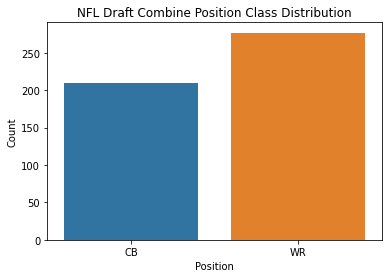

In [55]:
fig, ax = plt.subplots()
sns.countplot(x='Position',data=df)
ax.set_title('NFL Draft Combine Position Class Distribution')
ax.set_xticklabels(['CB', 'WR'])
ax.set_ylabel('Count')

Plot distribution for each feature in NFL Draft Combine dataset

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

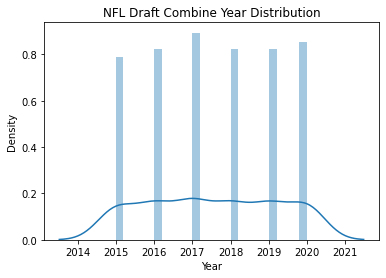

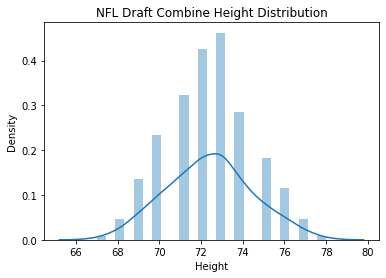

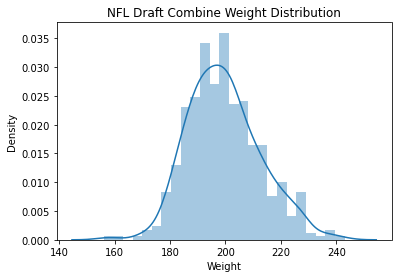

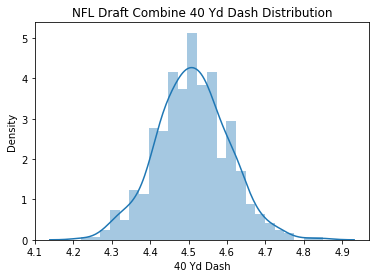

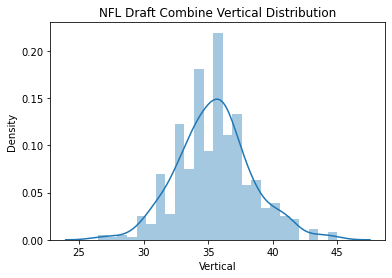

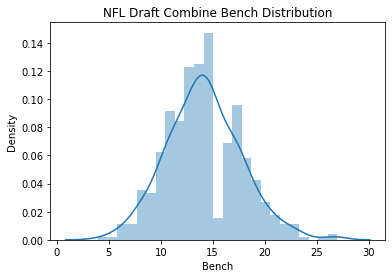

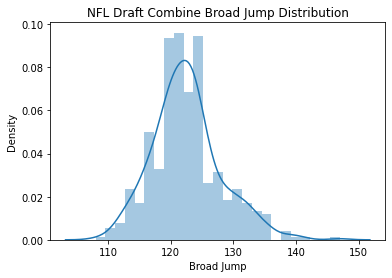

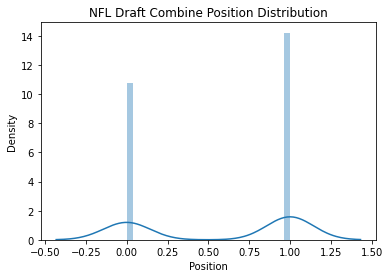

In [58]:
for feature in df.columns:
    fig1, ax1 = plt.subplots()
    sns.distplot(df[feature], kde=True, bins=25, ax=ax1)
    ax1.set_title(f'NFL Draft Combine {feature} Distribution')

Calculate vif for each feature to find correlated features

In [62]:
vif_x = df.drop(columns=['Position'])
vif_y = df['Position']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.2,
                                                                                random_state=91)
vif_df = add_constant(vif_x_train)


vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.round(decimals=1).reset_index(drop=True)

,Column,VIF
0,const,1426141.5
1,Weight,2.3
2,Height,2.1
3,Broad Jump,1.9
4,Vertical,1.9
5,40 Yd Dash,1.4
6,Bench,1.2
7,Year,1.0


Run t test for each feature to determine if there is a statistically significant difference between classes

In [89]:
ttest_x = df.drop(columns=['Position'])
ttest_y = df[['Position']]
ttest_x_train, ttest_x_test, ttest_y_train, ttest_y_test = train_test_split(ttest_x, ttest_y, test_size=0.2,
                                                                                random_state=91)
ttest = pd.concat([ttest_x_train, ttest_y_train], axis=1)

for feat in ttest_x.columns:
    print(f'{feat}: ')
    print('CB Mean: ', df[df['Position']==0][feat].mean())
    print('WR Mean: ', df[df['Position']==1][feat].mean())
    print(ttest_ind(ttest[ttest['Position']==0][feat], ttest[ttest['Position']==1][feat]))

Year: 
CB Mean:  2017.5
WR Mean:  2017.5415162454874
Ttest_indResult(statistic=-1.072180923955648, pvalue=0.2843069210419221)
Height: 
CB Mean:  71.70952380952382
WR Mean:  72.92057761732852
Ttest_indResult(statistic=-6.508199067689586, pvalue=2.3596001958464544e-10)
Weight: 
CB Mean:  193.8095238095238
WR Mean:  203.84115523465704
Ttest_indResult(statistic=-8.388961369194428, pvalue=9.28351874600664e-16)
40 Yd Dash: 
CB Mean:  4.499866666666667
WR Mean:  4.51789891696751
Ttest_indResult(statistic=-2.143714309917631, pvalue=0.03267843664227684)
Vertical: 
CB Mean:  35.83095238095238
WR Mean:  35.24187725631769
Ttest_indResult(statistic=2.583274440359049, pvalue=0.010152772217330946)
Bench: 
CB Mean:  14.221904761904764
WR Mean:  14.11985559566787
Ttest_indResult(statistic=0.3683400015424245, pvalue=0.7128211263070139)
Broad Jump: 
CB Mean:  123.33809523809524
WR Mean:  121.93429602888088
Ttest_indResult(statistic=3.2793420658552623, pvalue=0.001134728894760798)


# Model Data